In [4]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterio.plot import show, show_hist
import rasterio
import rasterio.mask as Mask
import rasterio.features
import rasterio.warp
from rasterio.plot import show_hist
import fiona
import os
from PIL import Image
import glob
import shapely
from shapely.geometry import LineString, Polygon, Polygon, Point, MultiPoint, MultiPolygon
from functools import partial
import pyproj
import shapely
from shapely.ops import transform
from tqdm import tqdm_notebook, tqdm
import nibabel as nib ## help save 3D images
## help with figure rotation
from scipy import ndimage, misc
from shapely.geometry import Point
import geopandas as gpd
import cv2   # usse to resize images so that every image would have the same size!!!! 
## GDAL_DATA environment problem
os.environ['GDAL_DATA'] = '/opt/anaconda3/pkgs/libgdal-2.3.3-h0950a36_0/share/gdal'
#bigquery_res = pd.read_csv('/Volumes/My Passport for Mac/landsat_path99_row85/bigquery_results.csv', index_col=0)
#len(bigquery_res)
import geopandas as gpd
fiona.drvsupport.supported_drivers['kml'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar


In [11]:
bigquery_res = pd.read_csv('/Volumes/My Passport for Mac/sentinel_2_53HPA/bigquery_results_s.csv', index_col=0)
bigquery_res['sensing_time'] = pd.to_datetime(bigquery_res['sensing_time'])
bigquery_res = bigquery_res.reset_index(drop=True)
subset_idx = np.array(bigquery_res[bigquery_res['cloud_cover']<75].index)
bigquery_res_s = bigquery_res.iloc[subset_idx,:]
bigquery_res_s = bigquery_res_s.reset_index(drop=True)


In [2]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def plot_rgb_from_tif(name='L1C_T53HPA_A004418_20180110T005319', 
                      BASE = '/Volumes/My Passport for Mac/sentinel_2_53HPA/', 
                      figsize=(20,20),
                      plot=True,
                      crop=False,
                      crop_dict=None
                     ):
    
    if crop is False:    
        b2 = rasterio.open(BASE+name+'_b02.tif').read(1)
        b3 = rasterio.open(BASE+name+'_b03.tif').read(1)
        b4 = rasterio.open(BASE+name+'_b04.tif').read(1)
    else:
        '''to be continued'''
        with rasterio.open(BASE+name+'_b02.tif') as src:
            out_image, out_transform = Mask.mask(src, A, crop=True)
    
    
    b2 = np.expand_dims(b2, axis=2)
    b3 = np.expand_dims(b3, axis=2)
    b4 = np.expand_dims(b4, axis=2)
    b2 = normalize(b2)
    b3 = normalize(b3)
    b4 = normalize(b4)
    rgb = np.concatenate([b4,b3,b2], 2)
    if plot is True:
        plt.figure(figsize=figsize)
        plt.imshow(rgb)
    return rgb

In [5]:
rgb = plot_rgb_from_tif(name='L1C_T53HPA_A009423_20181226T004702', plot=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


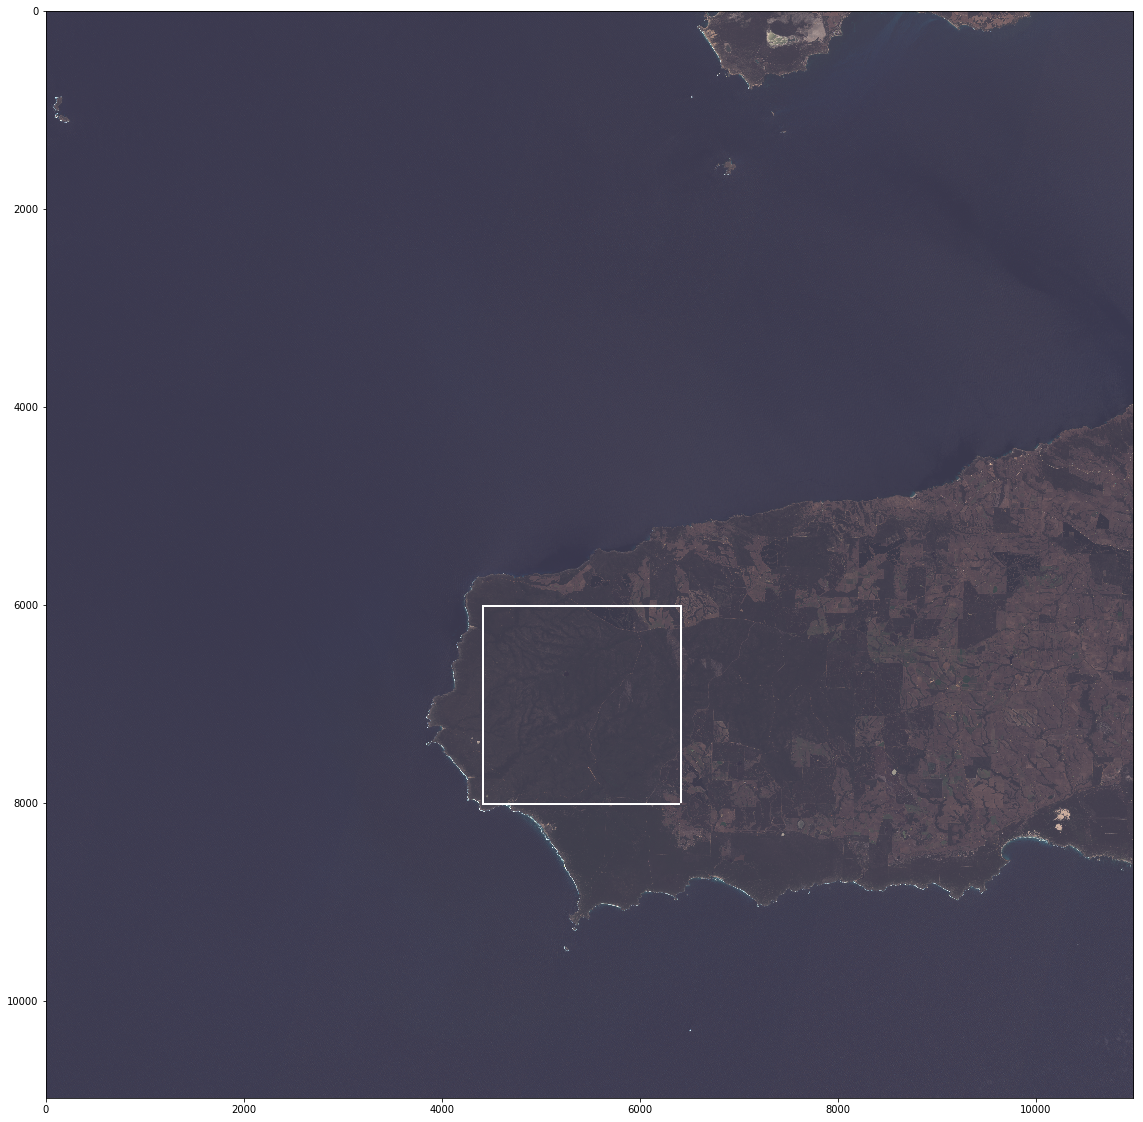

In [6]:
## Example RGB image
rgb[6000:8000,4400:4420,:] = 1
rgb[6000:8000,6400:6420,:] = 1
rgb[6000:6020,4400:6400,:] = 1
rgb[8000:8020,4400:6400,:] = 1

plt.figure(figsize=(20,20))
plt.imshow(rgb+0.2)

In [16]:
'''
rgb_list = []
for i in tqdm_notebook(range(len(bigquery_res_s))):
    rgb = plot_rgb_fom_tif_crop(name=bigquery_res_s['granule_id'][i], plot=False)
    rgb = np.expand_dims(rgb, 0)
    rgb_list.append(rgb)
rgb_array = np.array(rgb_list)
np.savez_compressed('rgb_array', rgb=rgb_array)
'''
rgb_array = np.load('/Users/jincui/Downloads/rgb_array.npz')['rgb']

In [22]:
imgs = np.load('/Users/jincui/Downloads/cloud_control_data.npz')['imgs']
smooth = 1e-5
b08 = imgs[:,:,:,7:8] 
b04 = imgs[:,:,:,3:4]
b12 = imgs[:,:,:,11:12]
ndvi= (b08-b04+smooth)/(b08+b04+smooth)
nbr = (b08-b12+smooth)/(b08+b12+smooth)

dndvi = []
for i in range(108):
    delta = ndvi[i+1,:] - ndvi[i,:]
    dndvi.append(delta)
dndvi = np.array(dndvi)

dnbr = np.load('../../cloud_control_data_dnbr.npz')['dnbr']
labs = (dnbr>0.66).astype(int)
water_mask = np.load('../../water_mask_based_on_ndvi_565.npy')
water_mask = np.expand_dims(water_mask, 2)
for i in range(len(labs)):
    labs[i,:][water_mask==1] = 0
    
dnbr = dnbr.astype('float64')
dnbr_medians = np.zeros(len(dnbr))
for i in range(len(dnbr)):
    dnbr_medians[i] = np.median(dnbr[i,:,:,0]).round(2)
 

In [25]:
zones_labs = []
for i in range(25):
    row_idx = (i//5)*200
    col_idx = (i%5)*200
    zones_labs.append(labs[:,row_idx:row_idx+200,col_idx:col_idx+200,0])
zones_risk = np.array([*map(lambda t:(t.sum(axis=-1).sum(axis=-1) >= (0.05*200*200)).astype(int), zones_labs)])
zones_risk = np.swapaxes(zones_risk,0,1)

risks = np.zeros(labs.shape)
from tqdm import tqdm_notebook
for i in tqdm_notebook(range(25)):
    row_idx = (i//5)*200
    col_idx = (i%5)*200
    for j in range(len(labs)):
        if labs[j,row_idx:row_idx+200,col_idx:col_idx+200,0].sum() >= 0.05*200*200:
            risks[j,row_idx:row_idx+200,col_idx:col_idx+200,0] = 1

In [223]:
folds_0 = np.load('/Users/jincui/Downloads/preds_0.npy').reshape((5,-1))
folds_1 = np.load('/Users/jincui/Downloads/preds_1.npy').reshape((5,-1))
folds_2 = np.load('/Users/jincui/Downloads/preds_2.npy').reshape((5,-1))
folds_3 = np.load('/Users/jincui/Downloads/preds_3.npy').reshape((5,-1))
folds_4 = np.load('/Users/jincui/Downloads/preds_4.npy').reshape((5,-1))

oof = np.concatenate([folds_0, folds_1, folds_2, folds_3, folds_4],0).transpose()
oof.shape

(106, 25)

In [209]:
'''
for i in tqdm_notebook(range(108)):
    '''Recursively generate figures for my Dash app'''
    thres = 0.66
    subtitle_fontsize=20
    title_fontsize=15

    plt.figure(figsize=(18,18))
    plt.suptitle(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i+1]}", fontsize=subtitle_fontsize)

    plt.subplot(3,3,1)
    plt.grid()
    plt.imshow(rgb_array[i+1,0,:,:,:])
    plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
    plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
    plt.title("True color (RGB)", fontsize=title_fontsize)

    plt.subplot(3,3,2)
    plt.grid()
    plt.imshow(ndvi[i+1,:,:,0], cmap='PiYG', vmin=-1, vmax=1)
    plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
    plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
    plt.title(f"Normalized vegetation index (NDVI)\nMedian NDVI: {np.median(ndvi[i+1,:,:,0]).round(2)}", fontsize=title_fontsize)

    plt.subplot(3,3,3)
    plt.grid()
    plt.imshow(dndvi[i,:,:,0], cmap='PiYG', vmin=-1, vmax=1)
    plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
    plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
    plt.title(f"Delta NDVI (dNDVI)\nMedian dNDVI: {np.median(dndvi[i,:,:,0]).round(2)}", fontsize=title_fontsize)

    plt.subplot(3,3,4)
    plt.grid()
    plt.imshow(nbr[i+1,:,:,0], cmap='RdYlGn_r', vmin=-1, vmax=1)
    plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
    plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
    plt.title(f"Normalized burn ratio (NBR)\nMedian NBR: {np.median(nbr[i+1,:,:,0]).round(2)}", fontsize=title_fontsize)
    plt.subplot(3,3,5)
    plt.grid()
    plt.imshow(dnbr[i,:,:,0], cmap='RdYlGn_r', vmin=-1, vmax=1)
    plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
    plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
    plt.title(f"Delta NBR (dNBR)\nMedian dNBR: {np.median(dnbr[i,:,:,0]).round(2)}", fontsize=title_fontsize)

    plt.subplot(3,3,6)
    plt.grid()
    plt.imshow(labs[i,:,:,0].astype(int), cmap='Greys_r')
    plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
    plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
    plt.title(f"Burnt (dNBR>0.66) area: {(100*(labs[i,:,:,0].sum())/(1000*1000)).round(2)}%", fontsize=title_fontsize)

    plt.subplot(3,3,7)
    plt.grid()
    plt.imshow(risks[i,:,:,0], cmap='Greys_r', vmin=0, vmax=1)
                 
    #plt.imshow((dnbr[i,:,:,0]>thres).astype(int), cmap='Greys_r')
    plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
    plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
    plt.title(f"True labels\nHigh-risk (>=5% ground burnt) sectors: {zones_risk[i].sum()}", fontsize=title_fontsize)

    if i >=2 :
        plt.subplot(3,3,8)
        #cm = pd.DataFrame(preds_risks[i-1,:])
        cm = pd.DataFrame(oof[i-2,:].reshape((5,5)))
        annot = cm.apply(lambda t:t.round(3)).values
        sns.heatmap(cm, annot=annot, annot_kws={"size": 12}, cmap="Greys_r", cbar=False, vmin=0, vmax=1,
                   yticklabels=False,
                   xticklabels=False
                   )
        #plt.title(f"Predicted labels\n F2 score: {fbeta_score(zones_risk[i+1,:], (preds_risks[i-1,:]>0.5).flatten().astype(int), 2).round(3)}", fontsize=title_fontsize)
        plt.title(f"Predicted labels\n F2 score: {fbeta_score(zones_risk[i,:], (oof[i-2,:]>0.5).flatten().astype(int), 2).round(3)}", fontsize=title_fontsize)
    plt.savefig(f"../Dash_app/data/plot_folder/plot_{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i+1]}.png")
'''

SyntaxError: invalid syntax (<ipython-input-209-30121de7e68f>, line 3)

In [215]:
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, cohen_kappa_score, roc_auc_score, accuracy_score
y_true = zones_risk[2:].flatten()
y_pred = oof.round().flatten()
print(f"{recall_score(y_true, y_pred).round(3)}\t{fbeta_score(y_true, y_pred, 2).round(3)} \t {f1_score(y_true, y_pred).round(3)}\t{cohen_kappa_score(y_true, y_pred).round(3)}\t{roc_auc_score(y_true, y_pred).round(3)}\t{accuracy_score(y_true, y_pred).round(3)}\t{precision_score(y_true, y_pred).round(3)}")


0.902	0.711 	 0.54	0.502	0.91	0.917	0.385


In [214]:
for fold in range(5):
    MIN = fold*5
    MAX = fold*5+5
    y_true = zones_risk[2:,MIN:MAX].flatten()
    y_pred = oof[:,MIN:MAX].round().flatten()
    print(f'fold_{fold}')
    print(f"{recall_score(y_true, y_pred).round(3)}\t{fbeta_score(y_true, y_pred, 2).round(3)} \t {f1_score(y_true, y_pred).round(3)}\t{cohen_kappa_score(y_true, y_pred).round(3)}\t{roc_auc_score(y_true, y_pred).round(3)}\t{accuracy_score(y_true, y_pred).round(3)}\t{precision_score(y_true, y_pred).round(3)}")
    


fold_0
1.0	0.859 	 0.709	0.679	0.967	0.94	0.549
fold_1
0.96	0.719 	 0.522	0.486	0.937	0.917	0.358
fold_2
0.885	0.65 	 0.465	0.423	0.893	0.9	0.315
fold_3
0.947	0.643 	 0.434	0.401	0.929	0.911	0.281
fold_4
0.735	0.638 	 0.532	0.49	0.832	0.917	0.417


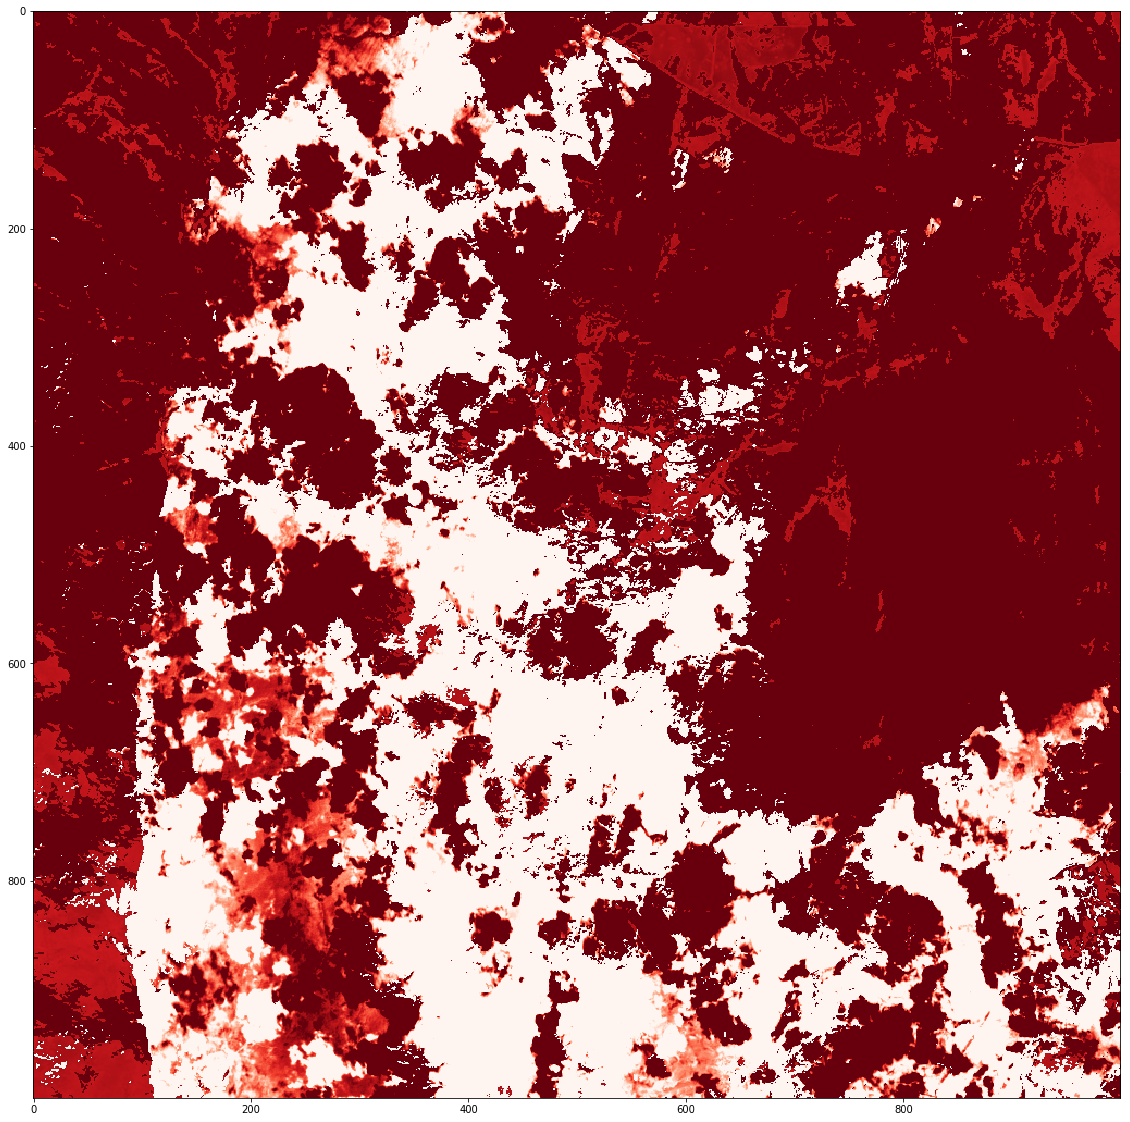

In [228]:
plt.figure(figsize=(20,20))
plt.imshow(dnbr[-1,:,:,0], cmap='Reds', vmin=-5, vmax=1)